# Analysis of an optimal solution

In [1]:
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx
from ItalySetupProvinces import ItalySetupProvinces
from covidOCP import COVIDAgeStructuredOCP, COVIDParametersOCP
from main import pick_scenario, build_scenario
import seaborn as sns
import datetime
import pickle
import glob
import networkx

mpl.rc('text', usetex=True)
mpl.rc('font', size=16)
mpl.rc('legend', fontsize=16)

nx = 9
states_names = ['S', 'E', 'P', 'I', 'A', 'Q', 'H', 'R', 'V']

ages_names = ['Y', 'M', 'O']
nc = 3

when = 'future'
file_prefix = f'week'
n_int_steps=15

objs = ['death','infection']

nnodes = 107  # nodes
ndays = 30

setup = ItalySetupProvinces(nnodes, ndays, when)
M = setup.nnodes
N = len(setup.model_days) - 1

with open(f'italy-data/parameters_{nnodes}_{when}.pkl', 'rb') as inp:
    p = pickle.load(inp)

Loaded Italy Setup with 107 nodes.


In [2]:
files_n = {'AG-death':  'helvetios-runs/2021-02-19-107_30_AG_death/ag-U-r15-t479700-id6-death-opt-107_30.csv',
           'NO':  'helvetios-runs/2021-02-19-107_30/week-U-r15-t479700-id6-opt-107_30.csv'}
baseline_fn = 'helvetios-runs/2021-02-19-107_30/week-U-r15-t479700-id6-int-107_30-nc.csv'
files_n['AG-infection'] = files_n['AG-death'].replace('death', 'infection')

In [7]:
scn_letter = 'U'
baseline_fn = glob.glob(f'model_output/scenarios_102_30/{scn_letter}*novacc*.csv')[0]

In [7]:
#dates_interm = pd.date_range(setup.start_date, setup.end_date, freq='30D')
#dates_interm

's'

In [3]:
results = {}

for scn, fn in files_n.items():
    
    bl = pd.read_csv(baseline_fn, index_col= 'date', parse_dates=True)
    md = pd.read_csv(fn, index_col= 'date', parse_dates=True)

    res = setup.shp.copy()
    res['vacc'] = np.nan
    res['Send'] = np.nan
    for i, node in enumerate(setup.ind2name):

        mdp = md[md['place']==node]
        blp = bl[bl['place']==node]

        total_vacc = mdp[ mdp['comp']=='vacc']['value'].sum()
        Send       = mdp[ mdp['comp']=='S']['value'][-1]
        Sstart     = mdp[ mdp['comp']=='S']['value'][0]
        ndays_vacc = len(mdp[(mdp['comp']=='vacc') & (mdp['value']>1)])
        total_inf  = mdp[ mdp['comp'].isin(['E', 'P', 'I', 'A', 'Q', 'H', 'R']) & (mdp.index == str(setup.end_date))]['value'].sum()
        new_inf    = mdp[ mdp['comp']=='yell']['value'].sum() # mdp[ mdp['comp'].isin(['E', 'P', 'I', 'A']) & (mdp.index == str(setup.end_date))]['value'].sum()
        new_inf_bl = blp[ blp['comp']=='yell']['value'].sum()

        res.loc[i, 'total_vacc'] = total_vacc
        res.loc[i, 'total_vacc_pop'] = total_vacc/setup.pop_node[i]
        res.loc[i, 'Send'] =       Send
        res.loc[i, 'Sstart'] =       Sstart
        res.loc[i, 'ndays_vacc'] = ndays_vacc
        res.loc[i, 'total_inf'] =  total_inf
        res.loc[i, 'new_inf'] =    new_inf
        res.loc[i, 'new_inf_bl'] =    new_inf_bl
        res.loc[i, 'averted'] = new_inf_bl - new_inf
        res.loc[i, 'averted_pop'] = (new_inf_bl - new_inf)/setup.pop_node[i]
        res.loc[i, 'Send_pop'] = Send/setup.pop_node[i]
        res.loc[i, 'population'] = setup.pop_node[i] # overwrite 

            #for dt in dates_interm:
            #    res.loc[i, f'total_vacc{str(dt.date())}'] = mdp[(mdp['comp']=='vacc') & (mdp.index < dt)]['value'].sum()
        results[scn] = res

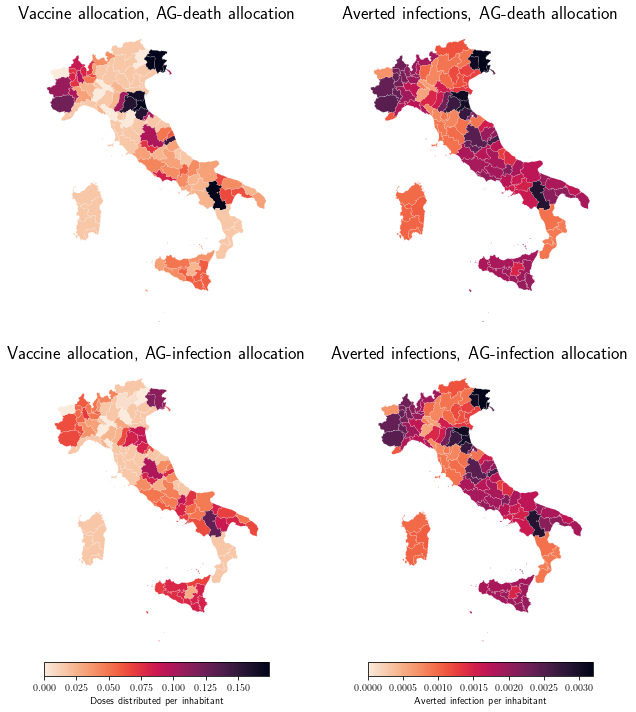

In [73]:
fig, axes_all = plt.subplots(2,2, figsize=(10, 10))
from mpl_toolkits.axes_grid1 import make_axes_locatable

res = {k:v for (k,v) in results.items() if 'NO' not in k}

plt_infos = {'total_vacc_pop': 
             {'legend':'Doses distributed per inhabitant',
              'title': 'Vaccine allocation',
               'vmax': max([max(rs['total_vacc_pop']) for met, rs in res.items()]),
               'vmin':0},
            'averted_pop': 
             {'legend':'Averted infection per inhabitant',
              'title': 'Averted infections',
               'vmax': max([max(rs['averted_pop']) for met, rs in res.items()]),
               'vmin':0}}


j = 0
for met, rs in res.items():
    axes = axes_all[j]
    j+=1
    for i, (colname, details) in enumerate(plt_infos.items()):
        ax=axes.flat[i]
        if j == 2:
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("bottom", size="5%", pad=0.1)
            mp = rs.plot(ax = ax, column=colname, 
                         cmap='rocket_r', 
                         lw = .1, 
                         edgecolor="white", 
                         vmin = details['vmin'],
                         vmax = details['vmax'],
                         cax = cax, 
                         legend=True, 
                         legend_kwds={'label': details['legend'],     'orientation': "horizontal"})
        else:
            #divider = make_axes_locatable(ax)
            #cax2 = divider.append_axes("bottom", size="5%", pad=0.1)
            mp = rs.plot(ax = ax, column=colname, 
                         cmap='rocket_r', 
                         lw = .1, 
                         edgecolor="white", 
                         vmin = details['vmin'],
                         vmax = details['vmax'])
        ax.set_title(details['title'] + f', {met} allocation', fontsize=18)
        ax.axis('off')
fig.tight_layout()
fig.savefig('figures/map_all_ag.pdf')

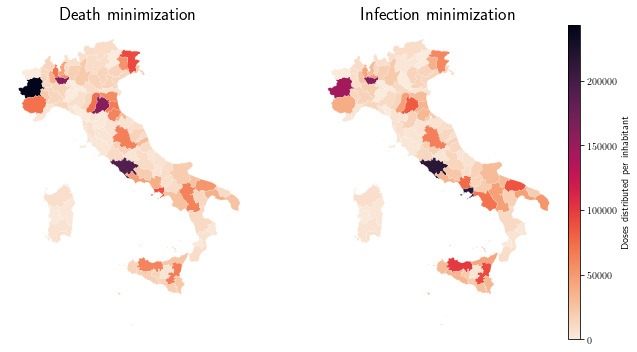

In [4]:
fig, axes = plt.subplots(1,2, figsize=(10, 5))
from mpl_toolkits.axes_grid1 import make_axes_locatable

res = {k:v for (k,v) in results.items() if 'NO' not in k}

plt_infos = {'total_vacc': 
             {'legend':'Doses distributed per inhabitant',
              'title': 'Vaccine allocation',
               'vmax': max([max(rs['total_vacc']) for met, rs in res.items()]),
               'vmin':0}}


j = 0
for i, (met, rs) in enumerate(res.items()):
    for  colname, details in plt_infos.items():
        ax=axes.flat[i]
        divider = make_axes_locatable(ax)
        if i == 1:
            cax = divider.append_axes("right", size="5%", pad=0.1)
            mp = rs.plot(ax = ax, column=colname, 
                         cmap='rocket_r', 
                         lw = .1, 
                         edgecolor="white", 
                         vmin = details['vmin'],
                         vmax = details['vmax'],
                         cax = cax, 
                         legend=True, 
                         legend_kwds={'label': details['legend'],     'orientation': "vertical"}
                        )
        else:
            mp = rs.plot(ax = ax, column=colname, 
             cmap='rocket_r', 
             lw = .1, 
             edgecolor="white", 
             vmin = details['vmin'],
             vmax = details['vmax'],
             legend=False
            )

        ax.set_title(f"{met.split('-')[-1].capitalize()} minimization", fontsize=18) # details['title'] + 
        ax.axis('off')
fig.tight_layout()
fig.savefig('figures/map_ag.pdf')

In [5]:
md = pd.read_csv(files_n['AG'], index_col= 'date', parse_dates=True)

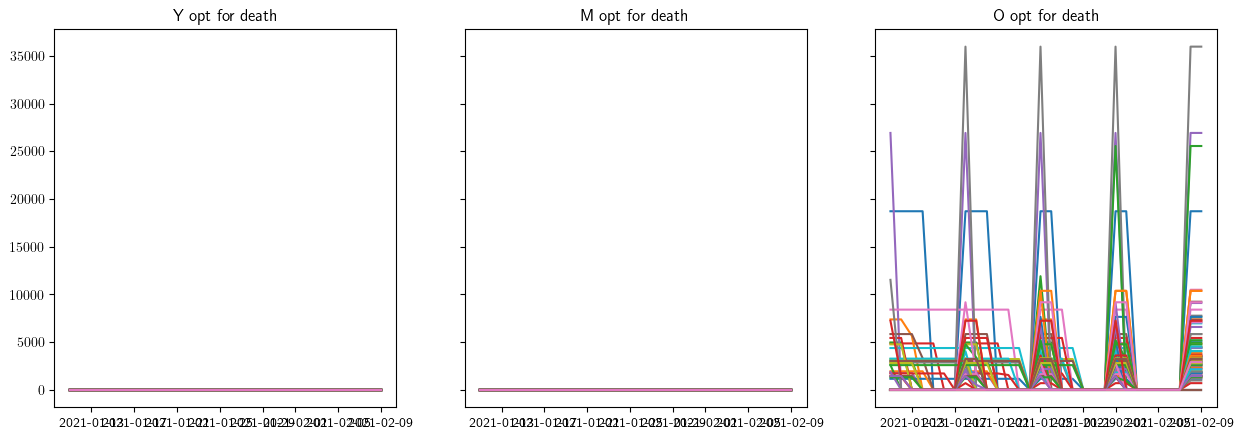

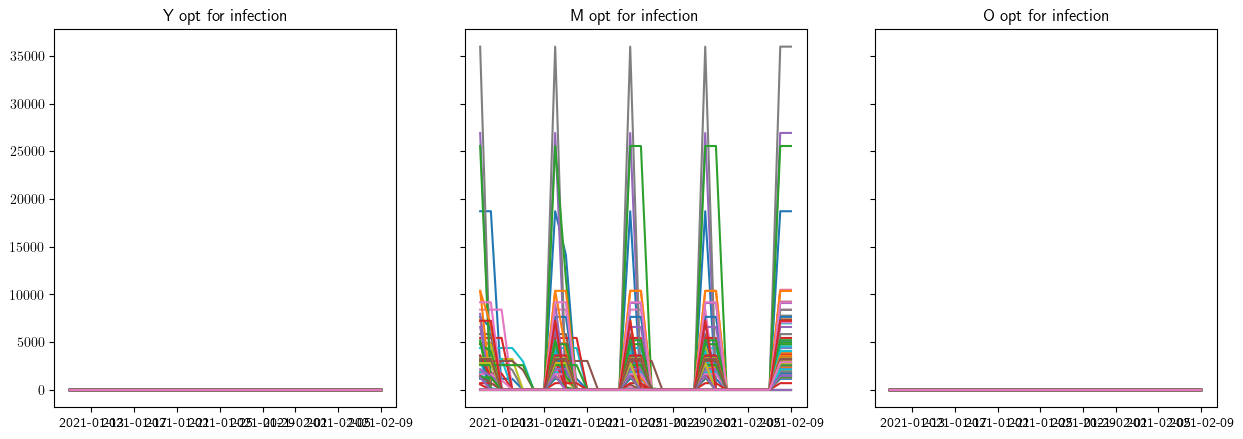

In [8]:
md = pd.read_csv(files_n['AG'], index_col= 'date', parse_dates=True)
mdv = md[(md['comp']=='vacc')]
cat = ['Y', 'M', 'O']

fig, axes = plt.subplots(1,3, figsize=(15,5), dpi = 100, sharey=True)



for i, ct in enumerate(cat):
    axes[i].plot(mdv[mdv['cat']==ct].pivot(values = 'value', columns=['placeID']))  # axes[i].set_ylim(0, 50000)
    axes[i].set_title(ct+' opt for death')
    #axes[i].set_ylim(0, 50000)
    
md = pd.read_csv(files_n['AG'].replace('death','infection'), index_col= 'date', parse_dates=True)
mdv = md[(md['comp']=='vacc')]
cat = ['Y', 'M', 'O']

fig, axes = plt.subplots(1,3, figsize=(15,5), dpi = 100, sharey=True)



for i, ct in enumerate(cat):
    axes[i].plot(mdv[mdv['cat']==ct].pivot(values = 'value', columns=['placeID']))
    axes[i].set_title(ct +' opt for infection')

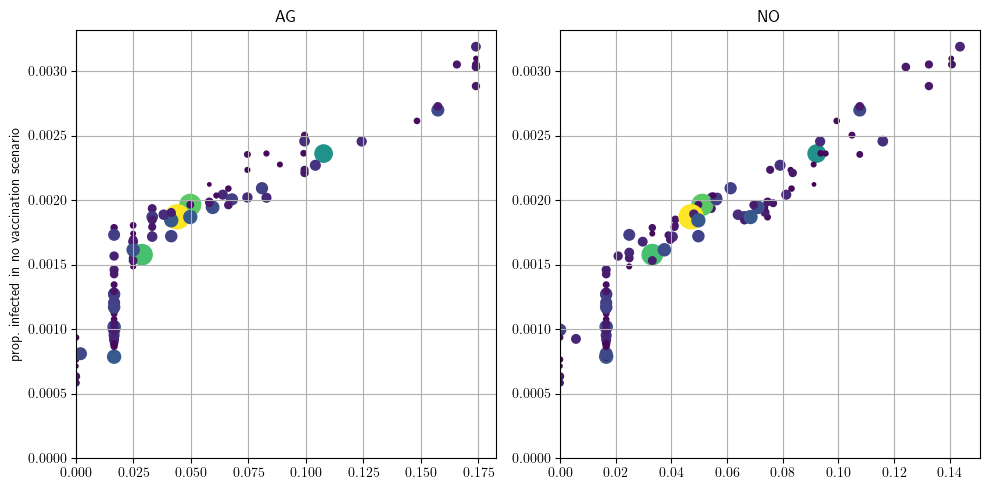

In [9]:
fig, axes = plt.subplots(1,2, figsize=(10,5), dpi = 100)


for i, (scn_name, res) in enumerate(results.items()):
    #res = res['Optimal']
    
    ax = axes[i]
    ax.scatter(res['total_vacc']/res['population'], 
               res['new_inf_bl']/res['population'], 
               s=res.population/max(res.population)*300, 
               c=res.population/max(res.population)*300)

    ax.grid()
    #ax.set( yscale="log", xscale="log") #
    #ax.set_xlabel('prop. optimal vaccine coverage')
    if i == 0: 
        ax.set_ylabel('prop. infected in no vaccination scenario')
    ax.set_title(f'{scn_name}')
    ax.set_xlim(0)
    ax.set_ylim(0)
    
fig.tight_layout()
fig.savefig('figures/scatter_ag.pdf')

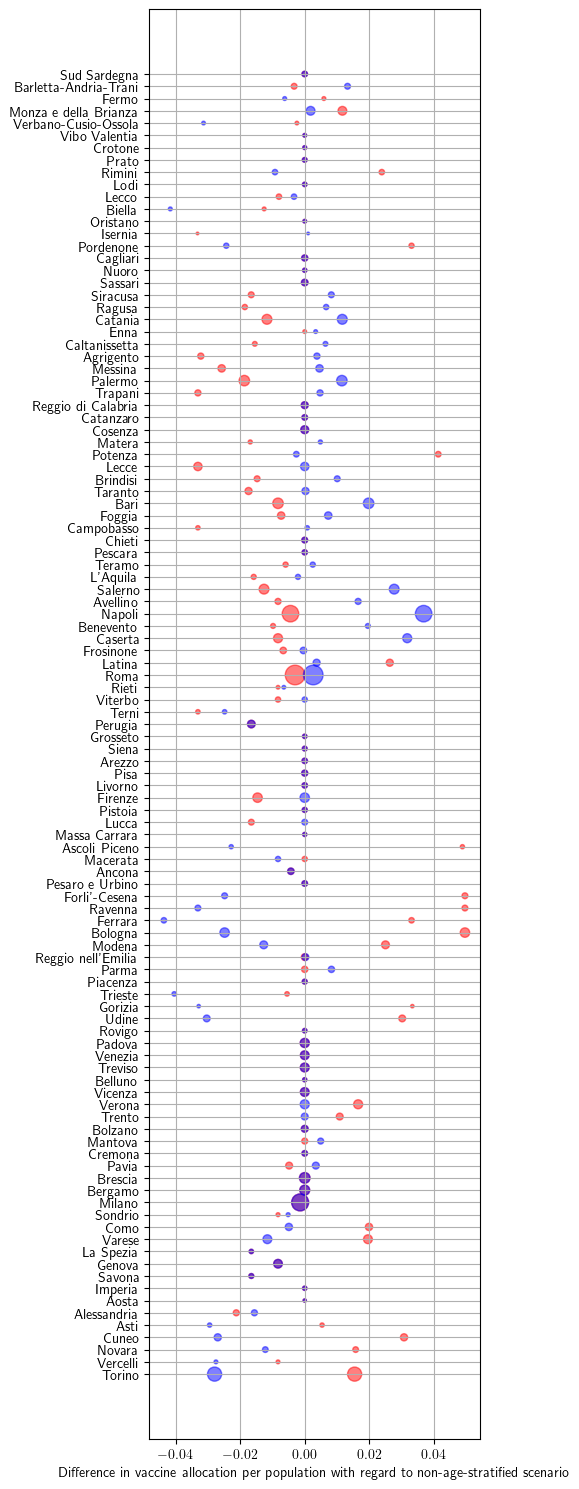

In [27]:
fig, axes = plt.subplots(1,1, figsize=(5,15), dpi = 100)
ax = axes

res = results['NO']
#ax.scatter(res['total_vacc']/res['population'], 
#           setup.ind2name,
#           s=res.population/max(res.population)*200, 
#           c='k')
nores = res['total_vacc']/res['population']

res = results['AG-death']
ax.scatter(res['total_vacc']/res['population']-nores, 
          setup.ind2name, 
           s=res.population/max(res.population)*200, 
           c='r', alpha = .5)

res = results['AG-infection']
ax.scatter(res['total_vacc']/res['population']-nores, 
           setup.ind2name, 
           s=res.population/max(res.population)*200, 
           c='b', alpha = .5)


ax.grid()
    #ax.set( yscale="log", xscale="log") #
    #ax.set_xlabel('prop. optimal vaccine coverage')

ax.set_xlabel('Difference in vaccine allocation per population with regard to non-age-stratified scenario')

#ax.set_xlim(0)
#ax.set_ylim(0)
    
fig.tight_layout()
fig.savefig('figures/scatter_ag.pdf')

In [3]:
files_n

{'AG-death': 'helvetios-runs/2021-02-19-107_30_AG_death/ag-U-r15-t479700-id6-death-opt-107_30.csv',
 'NO': 'helvetios-runs/2021-02-19-107_30/week-U-r15-t479700-id6-opt-107_30.csv',
 'AG-infection': 'helvetios-runs/2021-02-19-107_30_AG_infection/ag-U-r15-t479700-id6-infection-opt-107_30.csv'}

In [4]:
scenarios = {pick_scenario(setup, i)['name']:pick_scenario(setup, i) for i in np.arange(16)}
print(scenarios.keys())
scenario = scenarios['U-r3-t479700-id0']

dict_keys(['U-r3-t479700-id0', 'L-r3-t479700-id1', 'U-r15-t125000-id2', 'L-r15-t125000-id3', 'U-r15-t250000-id4', 'L-r15-t250000-id5', 'U-r15-t479700-id6', 'L-r15-t479700-id7', 'U-r15-t1000000-id8', 'L-r15-t1000000-id9', 'U-r15-t1500000-id10', 'L-r15-t1500000-id11', 'U-r15-t2000000-id12', 'L-r15-t2000000-id13', 'U-r150-t479700-id14', 'L-r150-t479700-id15'])


In [11]:
sims = {}
for scenario_name, fname in files_n.items():
   

        md = pd.read_csv(fname, index_col= 'date', parse_dates=True)

        control_initial = np.zeros((M, N, nc))

        #for k in range(ndays - 1):
        if scenario_name is not 'NO':
            md = md[md['comp'] == 'vacc']
            for nodename in md.place.unique():
                nd = setup.ind2name.index(nodename)
                mdn = md[md['place'] == nodename]

                for ag_id, ag in enumerate(ages_names):
                    to_allocate = mdn[mdn['cat']==ag].iloc[:-1]['value']
                    control_initial[nd, :, ag_id] = to_allocate

        p.apply_epicourse(setup, scenario['beta_mult'])
        # END Build scenario

        results, state_initial, yell_death, yell_infection, mob = COVIDAgeStructuredOCP.integrate(N,
                                                                          setup=setup,
                                                                          parameters=p,
                                                                          controls=control_initial,
                                                                          save_to=f'model_output/2021-02-19_ag/{scenario_name}',
                                                                          n_rk4_steps=n_int_steps)
        results.set_index('date', drop=True, inplace=True)
        sims[scenario_name] = results


  3%|▎         | 1/29 [00:00<00:09,  2.82it/s]

===> Integrating for model_output/2021-02-19_ag/AG-death


  0%|          | 0/29 [00:00<?, ?it/s]

===> Integrating for model_output/2021-02-19_ag/NO


  3%|▎         | 1/29 [00:00<00:09,  2.99it/s]

===> Integrating for model_output/2021-02-19_ag/AG-infection


100%|██████████| 29/29 [00:10<00:00,  2.87it/s]


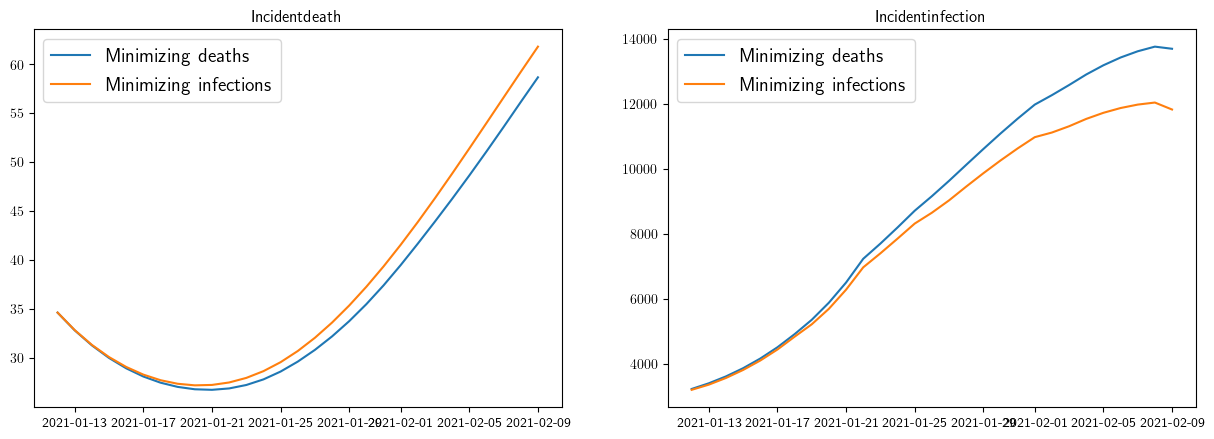

In [67]:

fig, axes = plt.subplots(1,2, figsize=(15,5), dpi = 100)



for i, qty in enumerate(objs):
    for obj in objs:
        mdv = sims[f'AG-{obj}']
        axes[i].plot(mdv[mdv['comp']==f'yell_{qty}'].pivot(values = 'value', columns=['placeID']).sum(axis=1).iloc[1:], label = f'Minimizing {obj}s')  # axes[i].set_ylim(0, 50000)
    axes[i].set_title('Incident' + qty)
    axes[i].legend()


In [27]:
mdNO = sims['NO']
averted = {}
for i, qty in enumerate(objs):
    averted[qty] = {}
    mdNO = sims['NO']
    mdNO = mdNO[mdNO['comp']==f'yell_{qty}'].pivot(values = 'value', columns=['placeID']).sum().sum()
    for obj in objs:
        mdv = sims[f'AG-{obj}']
        averted[qty][obj] = mdNO - mdv[mdv['comp']==f'yell_{qty}'].pivot(values = 'value', columns=['placeID']).sum().sum()
   

In [112]:
averted = pd.DataFrame.from_dict(averted)

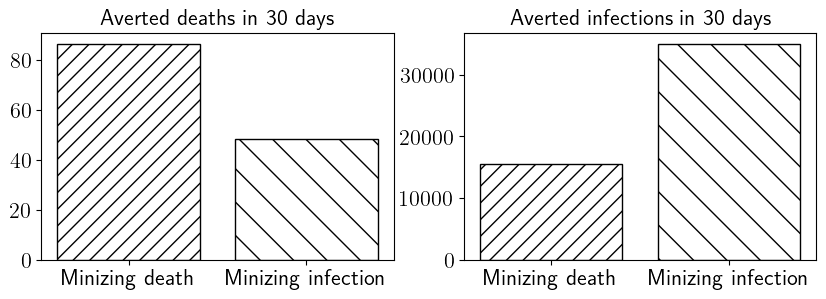

In [117]:
fig, axes = plt.subplots(1,2, figsize=(10,3), dpi = 100)
for i, qty in enumerate(objs):
    bars = axes[i].bar([f'Minizing {obj}' for obj in objs], averted[qty], color = 'white', edgecolor='black')
    axes[i].set_title(f'Averted {qty}s in 30 days', fontsize=16)
    patterns = ( '//', '\\') #  '*', 'o', 'O', '.','-', '+', 'x
    for bar, pattern in zip(bars, patterns):
        bar.set_hatch(pattern)
fig.savefig('figures/ag-hist.pdf')

In [61]:
results

,comp,place,cat,value,placeID
date,,,,,
2021-01-11,yell_infection,Torino,all,0.000000e+00,0
2021-01-12,yell_infection,Torino,all,1.658580e+02,0
2021-01-13,yell_infection,Torino,all,1.715475e+02,0
2021-01-14,yell_infection,Torino,all,1.819251e+02,0
2021-01-15,yell_infection,Torino,all,1.939986e+02,0
...,...,...,...,...,...
2021-02-05,V,Sud Sardegna,O,0.000000e+00,106
2021-02-06,V,Sud Sardegna,O,0.000000e+00,106
2021-02-07,V,Sud Sardegna,O,0.000000e+00,106


In [192]:
top = 10

a = sims['AG-death']
a = a[a['comp']=='vacc'].groupby('place').sum().sort_values('value', ascending=False)
a.reset_index(inplace=True)
a['place'] =  a['place'] + ', aged 65+'
a['Deaths'] = a['place']
a['# of doses'] = a['value'].astype(int)
c = a.drop(['placeID','value', 'place'], axis=1)

print(c.iloc[:top].to_latex(index = False))

\begin{tabular}{lr}
\toprule
            Deaths &  \# of doses \\
\midrule
  Torino, aged 65+ &      243321 \\
    Roma, aged 65+ &      191373 \\
  Milano, aged 65+ &      161546 \\
 Bologna, aged 65+ &      159688 \\
   Udine, aged 65+ &       91987 \\
  Napoli, aged 65+ &       88571 \\
  Modena, aged 65+ &       73437 \\
   Cuneo, aged 65+ &       72950 \\
  Varese, aged 65+ &       72061 \\
 Ravenna, aged 65+ &       67749 \\
\bottomrule
\end{tabular}



In [193]:
a = sims['AG-infection']
a = a[a['comp']=='vacc'].groupby('place').sum().sort_values('value', ascending=False)
a.reset_index(inplace=True)
a['place'] =  a['place'] + ', aged 16-65'
a['Infections'] = a['place']
a['# of doses'] = a['value'].astype(int)
b = a.drop(['placeID','value', 'place'], axis=1)

print(b.iloc[:top].to_latex(index = False))

\begin{tabular}{lr}
\toprule
          Infections &  \# of doses \\
\midrule
  Napoli, aged 16-65 &      216020 \\
    Roma, aged 16-65 &      215816 \\
  Milano, aged 16-65 &      161546 \\
  Torino, aged 16-65 &      145155 \\
 Palermo, aged 16-65 &      100155 \\
 Catania, aged 16-65 &       91758 \\
    Bari, aged 16-65 &       87043 \\
 Bologna, aged 16-65 &       84046 \\
 Caserta, aged 16-65 &       75224 \\
 Salerno, aged 16-65 &       71655 \\
\bottomrule
\end{tabular}



In [198]:
t = pd.concat([b.iloc[:top], pd.DataFrame(['']*top, columns=['']), c.iloc[:top]], axis = 1)
t.index = np.arange(1,top+1)
t.index.name = 'rank'
print(t.to_latex())

\begin{tabular}{llrllr}
\toprule
{} &           Infections & \multicolumn{2}{l}{\# of doses} &             Deaths &  \# of doses \\
rank &                      &             &   &                    &             \\
\midrule
1    &   Napoli, aged 16-65 &      216020 &   &   Torino, aged 65+ &      243321 \\
2    &     Roma, aged 16-65 &      215816 &   &     Roma, aged 65+ &      191373 \\
3    &   Milano, aged 16-65 &      161546 &   &   Milano, aged 65+ &      161546 \\
4    &   Torino, aged 16-65 &      145155 &   &  Bologna, aged 65+ &      159688 \\
5    &  Palermo, aged 16-65 &      100155 &   &    Udine, aged 65+ &       91987 \\
6    &  Catania, aged 16-65 &       91758 &   &   Napoli, aged 65+ &       88571 \\
7    &     Bari, aged 16-65 &       87043 &   &   Modena, aged 65+ &       73437 \\
8    &  Bologna, aged 16-65 &       84046 &   &    Cuneo, aged 65+ &       72950 \\
9    &  Caserta, aged 16-65 &       75224 &   &   Varese, aged 65+ &       72061 \\
10   &  Salerno, ag